In [ ]:
from google.colab import drive
drive.mount('/content/drive')

7/7 ━━━━━━━━━━━━━━━━━━━━ 67s 8s/step


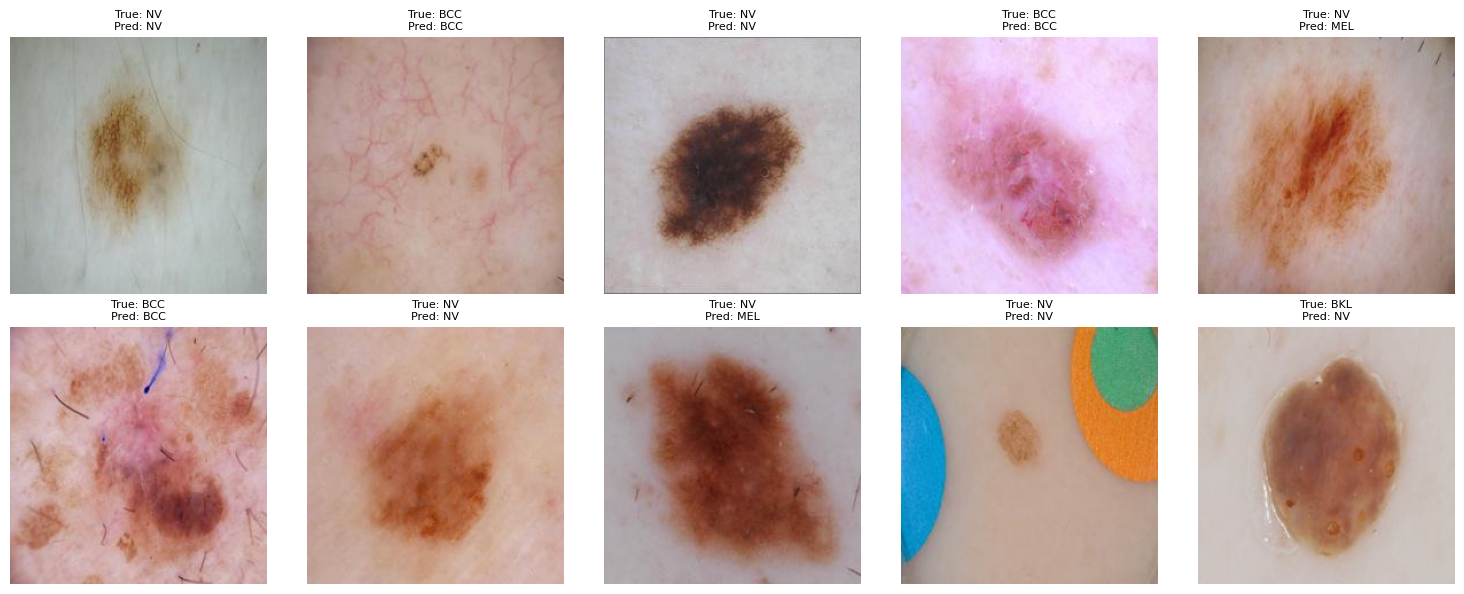

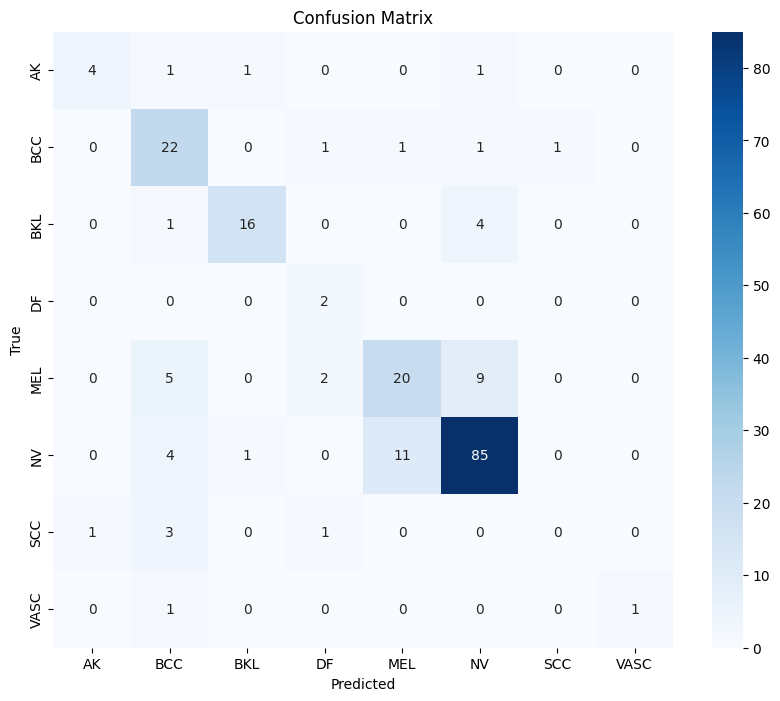

              precision    recall  f1-score   support

          AK       0.80      0.57      0.67         7
         BCC       0.59      0.85      0.70        26
         BKL       0.89      0.76      0.82        21
          DF       0.33      1.00      0.50         2
         MEL       0.62      0.56      0.59        36
          NV       0.85      0.84      0.85       101
         SCC       0.00      0.00      0.00         5
        VASC       1.00      0.50      0.67         2

    accuracy                           0.75       200
   macro avg       0.64      0.63      0.60       200
weighted avg       0.75      0.75      0.74       200



In [1]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report
from PIL import Image
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model('/content/drive/MyDrive/PHD_MMU/Skin_Lesion_Classification/trained_models/DenseNet121_trained_model_50_epochs.keras')

# Preprocess function
def preprocess_image(image_path, target_size=(224, 224)):
    img = Image.open(image_path)
    img = img.resize(target_size)
    img = np.array(img)
    if img.shape[2] == 4:
        img = img[:, :, :3]
    img = img / 255.0
    return img

# Load and preprocess test images
test_image_folder = '/content/drive/MyDrive/PHD_MMU/Skin_Lesion_Classification/train_val_test_split/split_images/test/'
test_df = pd.read_csv(os.path.join(test_image_folder, 'test.csv'))
test_df['image'] = test_df['image'].apply(lambda x: x if x.endswith('.jpg') else x + '.jpg')

test_images = []
image_paths = []

for image_name in test_df['image']:
    image_path = os.path.join(test_image_folder, image_name)
    img = preprocess_image(image_path)
    test_images.append(img)
    image_paths.append(image_path)

test_images = np.array(test_images)

# Make predictions
predictions = model.predict(test_images)
predicted_classes = np.argmax(predictions, axis=1)

# Define the label encoder classes
le_classes = ['AK', 'BCC', 'BKL', 'DF', 'MEL', 'NV', 'SCC', 'VASC']
le = LabelEncoder()
le.fit(le_classes)

predicted_class_names = le.inverse_transform(predicted_classes)
true_class_names = test_df['combined_class'].values

# Add predictions to the test dataframe
test_df['predicted_class'] = predicted_class_names

# Display images with their ground truth and predicted labels
num_images_to_display = 10
fig, axes = plt.subplots(2, 5, figsize=(15, 6))
axes = axes.flatten()

for i, (img_path, true_class, pred_class) in enumerate(zip(image_paths[:num_images_to_display], true_class_names[:num_images_to_display], predicted_class_names[:num_images_to_display])):
    img = Image.open(img_path)
    axes[i].imshow(img)
    axes[i].set_title(f"True: {true_class}\nPred: {pred_class}", fontsize=8)
    axes[i].axis('off')

plt.tight_layout()
plt.show()

# Compute confusion matrix
cm = confusion_matrix(true_class_names, predicted_class_names, labels=le_classes)

# Plot heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le_classes, yticklabels=le_classes)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Print classification report
print(classification_report(true_class_names, predicted_class_names, target_names=le_classes))
